In [8]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14958323829355149910,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10081009664
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16443926071426643424
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6"]

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.regularizers import l2
import os
import numpy as np
import xml.etree.ElementTree as ET
import functools
from tensorflow.keras.optimizers import RMSprop


strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # 데이터증강기법
    train_directory = 'E:/종설/Training/1/[원천]면류'
    train_images = []
    train_labels = []
    for class_label in os.listdir(train_directory):
        class_directory = os.path.join(train_directory, class_label)
        for image_name in os.listdir(class_directory):
            image_path = os.path.join(class_directory, image_name)
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=(256, 256))
            image = tf.keras.preprocessing.image.img_to_array(image)
            image = image / 255.0  # 정규화
            train_images.append(image)
            train_labels.append(class_label)

    train_images = np.array(train_images)
    train_labels = np.array(train_labels)

    np.save('train_images.npy', train_images)
    np.save('train_labels.npy', train_labels) 
    
    train_images = np.load('train_images.npy')
    train_labels = np.load('train_labels.npy')

    # 데이터증강기법
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        preprocessing_function=lambda img: tf.image.random_crop(img, [256, 256, 3])
    )

    train_dataset = train_datagen.flow(
        x=train_images,
        y=train_labels,
        batch_size=120,
        seed=42,
        shuffle=True
    )
    
    val_directory = 'E:/종설/Validation/1/[원천]면류'
    val_images = []
    val_labels = []
    for class_label in os.listdir(val_directory):
        class_directory = os.path.join(val_directory, class_label)
        for image_name in os.listdir(class_directory):
            image_path = os.path.join(class_directory, image_name)
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=(256, 256))
            image = tf.keras.preprocessing.image.img_to_array(image)
            image = image / 255.0  # 정규화
            val_images.append(image)
            val_labels.append(class_label)

    val_images = np.array(val_images)
    val_labels = np.array(val_labels)

    np.save('val_images.npy', val_images)
    np.save('val_labels.npy', val_labels)
    
    val_images = np.load('val_images.npy')
    val_labels = np.load('val_labels.npy')

    # 크기조정만
    val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

    val_dataset = val_datagen.flow(
        x=val_images,
        y=val_labels,
        batch_size=120,
        shuffle=False
    )

    # EfficientNet-B0모델 불러오기
    pretrained_model = hub.KerasLayer("https://tfhub.dev/google/efficientnet/b0/feature-vector/1", trainable=False)

    # 층 추가
    model = Sequential()
    model.add(pretrained_model)
    model.add(Dropout(0.3))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(train_dataset.num_classes, activation='softmax', kernel_regularizer=l2(0.0005)))

    # 컴파일 - 학습률조정
    model.compile(
        optimizer=RMSprop(lr=0.0005),  # Use RMSprop as the optimizer
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    num_epochs = 50
    best_val_acc = 0.0


    history = model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=val_dataset,
    )

    # Save the model
    best_val_acc = max(history.history['val_accuracy'])
    model.save('my_model_noodle_v6.h5')
    

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


KeyboardInterrupt: 

In [2]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              4049564   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 205)               105165    
Total params: 4,810,601
Trainable params: 761,037
Non-trainable params: 4,049,564
_________________________________________________________________


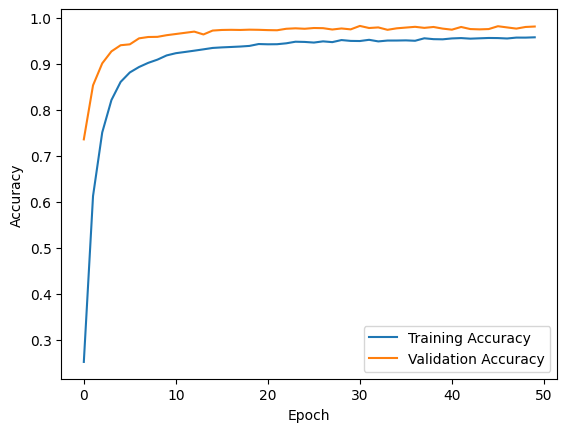

In [8]:
import matplotlib.pyplot as plt

# Get the accuracy values from history object
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot the accuracy values
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [17]:
import os
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt

# 라벨링에 사용할 txt파일 만들기
directory = 'E:/종설/Training/1/[원천]면류'

class_labels = []
for filename in os.listdir(directory):
    if os.path.isdir(os.path.join(directory, filename)):
        class_labels.append(filename)

with open('class_labels_noodle.txt', 'w') as file:
    for label in class_labels:
        file.write(label + '\n')

        
        
# 모델불러오기
model = tf.keras.models.load_model('model_trained_in_NEURON_v2.h5', custom_objects={'KerasLayer': hub.KerasLayer})

# 이미지 불러오기(jpg or png파일형식)
img_path = r'C:\Users\sj990\Desktop\ex\image.png'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
img = tf.keras.preprocessing.image.img_to_array(img)
img = img.astype('float32') / 255.0
img = np.expand_dims(img, axis=0)

# 이미지 예측
preds = model.predict(img)

# 라벨링된 txt파일 불러와서 사용
class_labels = []
with open('class_labels_noodle.txt', 'r') as file:
    for line in file:
        class_labels.append(line.strip())

# top3 결과순위
top_preds_idx = preds[0].argsort()[::-1][:3]
top_preds_labels = [class_labels[idx] for idx in top_preds_idx]
top_preds_probs = preds[0][top_preds_idx]

# 출력
i = 1
for label, prob in zip(top_preds_labels, top_preds_probs):
    print(f"결과순위 {i}: {label} ({prob:.2f})")
    i += 1

결과순위 1: 15824_조이인터내셔널마마컵쉬림크리미톰얌플레이버70G (0.25)
결과순위 2: 15823_농심새우탕컵(소)67G (0.25)
결과순위 3: 65051_엠디에스코리아아라비아따파스타 (0.16)


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.regularizers import l2
import os
import numpy as np
import xml.etree.ElementTree as ET
import functools
from tensorflow.keras.optimizers import RMSprop, Adam


strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # 데이터증강기법
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        preprocessing_function=lambda img: tf.image.random_crop(img, [256, 256, 3])
    )

    # 훈련 데이터셋
    train_directory = 'E:/종설/Training/1/[원천]면류'
    train_dataset = train_datagen.flow_from_directory(
        train_directory,
        target_size=(256, 256),
        batch_size=120,
        shuffle=True,
        seed=42,  # add a seed for reproducibility
        follow_links=True,  # follow symbolic links if any
        classes=None,  # set to None to use default class mode
    )
    
    # 크기조정만
    val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
    )

    # 검증데이터
    val_directory = 'E:/종설/Validation/1/[원천]면류'
    val_dataset = val_datagen.flow_from_directory(
        val_directory,
        target_size=(256, 256),
        batch_size=120,
        shuffle=False,
        classes=None,  # set to None to use default class mode
    )

    # EfficientNet-B0모델 불러오기
    pretrained_model = hub.KerasLayer("https://tfhub.dev/google/efficientnet/b0/feature-vector/1", trainable=False)

    # 층 추가
    model = Sequential()
    model.add(pretrained_model)
    model.add(Dropout(0.3))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(train_dataset.num_classes, activation='softmax', kernel_regularizer=l2(0.0005)))

    initial_learning_rate = 0.048
    momentum = 0.9
    weight_decay = 0.00004
    dropout_rate = 0.2
    num_epochs = 50

    def lr_schedule(epoch):
        initial_lr = initial_learning_rate
        decay_factor = 0.97
        decay_epochs = 2.4
        lr = initial_lr * (decay_factor ** (epoch // decay_epochs))
        return lr

    optimizer = Adam(learning_rate=initial_learning_rate, beta_1=momentum, decay=weight_decay)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    lr_scheduler = LearningRateScheduler(lr_schedule)
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('my_model_noodle_v5.h5', monitor='val_accuracy', save_best_only=True)

    history = model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=val_dataset,
        callbacks=[lr_scheduler, early_stopping, model_checkpoint]
    )

    best_val_acc = max(history.history['val_accuracy'])
    print("Best validation accuracy:", best_val_acc)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Found 23370 images belonging to 205 classes.
Found 3075 images belonging to 205 classes.
Epoch 1/50
195/195 [==============================] - 3039s 16s/step - loss: 5.1028 - accuracy: 0.0998 - val_loss: 3.6484 - val_accuracy: 0.1613
Epoch 2/50
195/195 [==============================] - 3235s 17s/step - loss: 3.7728 - accuracy: 0.1621 - val_loss: 3.3577 - val_accuracy: 0.2247
Epoch 3/50
195/195 [==============================] - 3014s 15s/step - loss: 3.5621 - accuracy: 0.1969 - val_loss: 3.2893 - val_accuracy: 0.2407
Epoch 4/50
195/195 [==============================] - 3058s 16s/step - loss: 3.4352 - accuracy: 0.2081 - val_loss: 3.2290 - val_accuracy: 0.2433
Epoch 5/50
195/195 [==============================] - 3006s 15s/step - loss: 3.4191 - accuracy: 0.2212 - val_loss: 3.0099 - val_accuracy: 0.2345
Epoch 6/50
195/195 [==============================] - 3102s 16s/step - loss: 3.3271 - accuracy: 0.2309 - val_loss: 3.0105 - val_accuracy: 0.2579
Epoch 7/50
195/195 [=====================

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.regularizers import l2
import os
import numpy as np
import xml.etree.ElementTree as ET
import functools
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint

strategy = tf.distribute.MirroredStrategy()

# Define a function to create the model architecture
def create_model():
    # EfficientNet-B0모델 불러오기
    pretrained_model = hub.KerasLayer("https://tfhub.dev/google/efficientnet/b0/feature-vector/1", trainable=False)

    # 층 추가
    model = Sequential()
    model.add(pretrained_model)
    model.add(Dropout(0.3))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(train_dataset.num_classes, activation='softmax', kernel_regularizer=l2(0.0005)))

    return model

with strategy.scope():
    # 데이터증강기법
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        preprocessing_function=lambda img: tf.image.random_crop(img, [256, 256, 3])
    )

    # 훈련 데이터셋
    train_directory = 'E:/종설/Training/1/[원천]면류'
    train_dataset = train_datagen.flow_from_directory(
        train_directory,
        target_size=(256, 256),
        batch_size=120,
        shuffle=True,
        seed=42,  # add a seed for reproducibility
        follow_links=True,  # follow symbolic links if any
        classes=None,  # set to None to use default class mode
    )
    
    # 크기조정만
    val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
    )

    # 검증데이터
    val_directory = 'E:/종설/Validation/1/[원천]면류'
    val_dataset = val_datagen.flow_from_directory(
        val_directory,
        target_size=(256, 256),
        batch_size=120,
        shuffle=False,
        classes=None,  # set to None to use default class mode
    )

    initial_learning_rate = 0.048
    momentum = 0.9
    weight_decay = 0.00004
    dropout_rate = 0.2
    num_epochs = 50

    def lr_schedule(epoch):
        initial_lr = initial_learning_rate
        decay_factor = 0.97
        decay_epochs = 2.4
        lr = initial_lr * (decay_factor ** (epoch // decay_epochs))
        return lr

    optimizer = Adam(learning_rate=initial_learning_rate, beta_1=momentum, decay=weight_decay)

    # Checkpoint callback to save the model weights
    model_checkpoint = ModelCheckpoint('my_model_noodle_v5.h5', monitor='val_accuracy', save_best_only=True)

    # Load the model and weights if they exist
    if os.path.exists('my_model_noodle_v5.h5'):
        model = tf.keras.models.load_model('my_model_noodle_v5.h5')
        print("Model loaded successfully!")
    else:
        # Create a new model if no saved model found
        model = create_model()

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    lr_scheduler = LearningRateScheduler(lr_schedule)
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

    history = model.fit(
        train_dataset,
        epochs=num_epochs,
        initial_epoch=0,  # Start from the epoch you left off
        validation_data=val_dataset,
        callbacks=[lr_scheduler, early_stopping, model_checkpoint]
    )

    best_val_acc = max(history.history['val_accuracy'])
    print("Best validation accuracy:", best_val_acc)